In [1]:
import os
import pandas as pd

import torch
from efficientnet_pytorch import EfficientNet
import wandb

from fastai2.basics import *
from fastai2.data.all import *
from fastai2.callback.all import *
from fastai2.callback.wandb import *
from fastai2.vision.all import *
from sklearn.metrics import recall_score

## Params

In [2]:
NAME = ''
WANDB_MODE = 'dryrun'

DATA_PATH = Path('/home/lextoumbourou/bengaliai-cv19/data')
IMAGE_DATA_PATH = Path(DATA_PATH/'grapheme-imgs-128x128')
OUTPUT_PATH = Path(DATA_PATH/'working')
LABELS_PATH  = Path(DATA_PATH/'iterative-stratification')

VALID_PCT = 0.2
SEED = 420
BATCH_SIZE = 64
IMG_SIZE = 64

MAX_WARP = 0.2
P_AFFINE = 0.75
MAX_ROTATE = 10.
MAX_ZOOM = 1.1
P_LIGHTING = 0.75
MAX_LIGHTING = 0.2
MAX_COUNT_RANDOM_ERASING = 3

ENCODER_ARCH = 'efficientnet-b0'

GRAPHEME_ROOT_WEIGHT = 2
VOWEL_DIACRITIC_WEIGHT = 1
CONSONANT_DIACRITIC_WEIGHT = 1

SAMPLE_SIZE = None
if not torch.cuda.is_available():
    SAMPLE_SIZE = 10_000

In [3]:
# Parameters
WANDB_MODE = "run"
NAME = "fastai2-baseline"
OUTPUT_VAL_SIZE = None


In [4]:
!wandb login 563765550fd7b64fd10129216209724e03f3f20c

wandb: Appending key for api.wandb.ai to your netrc file: /home/lextoumbourou/.netrc
Successfully logged in to Weights & Biases!


In [5]:
# Turn this off before running!!
os.environ['WANDB_MODE'] = WANDB_MODE

In [6]:
wandb.init(project="bengaliai-cv19", name=NAME)

wandb.config.img_size = IMG_SIZE
wandb.config.batch_size = BATCH_SIZE
wandb.config.seed = SEED

wandb.config.max_warp = MAX_WARP
wandb.config.p_affine = P_AFFINE
wandb.config.max_rotate = MAX_ROTATE
wandb.config.max_zoom = MAX_ZOOM
wandb.config.p_lighting = P_LIGHTING
wandb.config.max_lighting = MAX_LIGHTING
wandb.config.max_count_random_erasing = MAX_COUNT_RANDOM_ERASING
wandb.config.grapheme_root_weight = GRAPHEME_ROOT_WEIGHT
wandb.config.vowel_diacritic_weight = VOWEL_DIACRITIC_WEIGHT
wandb.config.consonant_diacritic_weight = CONSONANT_DIACRITIC_WEIGHT
wandb.config.sample_size = SAMPLE_SIZE
wandb.config.ENCODER_ARCH = ENCODER_ARCH

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


## Create datasets and dataloaders

In [7]:
aug_kwargs = dict(size=wandb.config.img_size, mode='bilinear', pad_mode=PadMode.Reflection, batch=False)

AUGMENTATIONS = [
    Warp(magnitude=wandb.config.max_warp, p=wandb.config.p_affine, **aug_kwargs),
    Rotate(max_deg=wandb.config.max_rotate, p=wandb.config.p_affine, **aug_kwargs),
    Zoom(max_zoom=wandb.config.max_zoom, p=wandb.config.p_affine, **aug_kwargs),
    Brightness(max_lighting=wandb.config.max_lighting, p=wandb.config.p_lighting, batch=False),
    Contrast(max_lighting=wandb.config.max_lighting, p=wandb.config.p_lighting, batch=False),
    RandomErasing(max_count=wandb.config.max_count_random_erasing)
]

In [8]:
train_df = pd.read_csv(LABELS_PATH/'train_with_fold.csv')
if wandb.config.sample_size:
    print("About to reduce train size.")
    train_df = train_df.sample(n=wandb.config.sample_size, random_state=SEED).reset_index(drop=True)

In [9]:
imagenet_stats

([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [10]:
datablock = DataBlock(
    blocks=(ImageBlock(cls=PILImageBW), CategoryBlock, CategoryBlock, CategoryBlock),
    getters=[
        ColReader('image_id', pref=IMAGE_DATA_PATH, suff='.png'),
        ColReader('grapheme_root'),
        ColReader('vowel_diacritic'),
        ColReader('consonant_diacritic')
    ],
    splitter=IndexSplitter(train_df.loc[train_df.fold==0].index))

In [11]:
tfms = AUGMENTATIONS + [Normalize(mean=0.485, std=0.229)]

In [12]:
tfms

[AffineCoordTfm: True (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ,
 AffineCoordTfm: True (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ,
 AffineCoordTfm: True (TensorBBox,object) -> encodes
 (TensorPoint,object) -> encodes
 (TensorImage,object) -> encodes
 (TensorMask,object) -> encodes ,
 LightingTfm: True (TensorImage,object) -> encodes ,
 LightingTfm: True (TensorImage,object) -> encodes ,
 RandomErasing: False (TensorImage,object) -> encodes ,
 Normalize: True (TensorImage,object) -> encodes (TensorImage,object) -> decodes]

In [13]:
data = datablock.dataloaders(train_df, bs=wandb.config.batch_size, batch_tfms=tfms)
data.n_inp = 1 

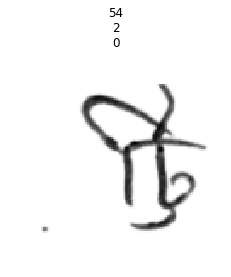

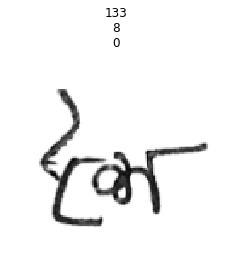

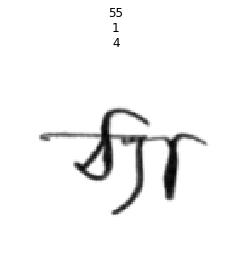

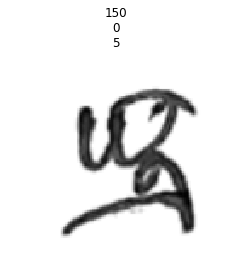

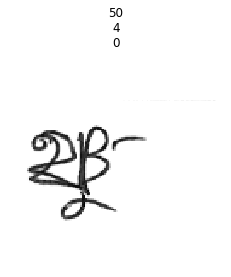

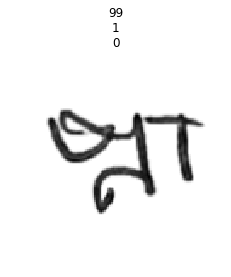

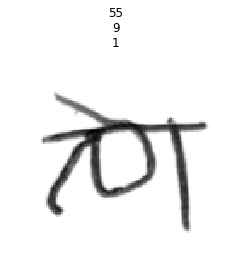

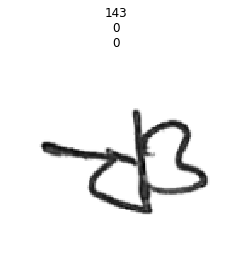

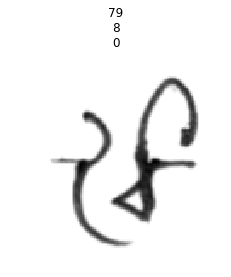

In [14]:
data.show_batch()

## Loss and metrics

In [15]:
def loss_func(inp, grapheme_root_targ, vowel_diacritic_targ, consonant_diacritic_targ, *args, **kwargs):
    grapheme_root_inp, vowel_diacritic_inp, consonant_diacritic_inp = inp

    return (
        F.cross_entropy(grapheme_root_inp, grapheme_root_targ) * wandb.config.grapheme_root_weight +
        F.cross_entropy(vowel_diacritic_inp, vowel_diacritic_targ) * wandb.config.vowel_diacritic_weight +
        F.cross_entropy(consonant_diacritic_inp, consonant_diacritic_targ) * wandb.config.consonant_diacritic_weight
    )

In [16]:
class RecallPartial(Metric):
    """Stores predictions and targets on CPU in accumulate to perform final calculations with `func`."""
    def __init__(self, a=0, **kwargs):
        self.func = partial(recall_score, average='macro', zero_division=0)
        self.a = a

    def reset(self): self.targs,self.preds = [],[]

    def accumulate(self, learn):
        pred = learn.pred[self.a].argmax(dim=-1)
        targ = learn.y[self.a]
        pred,targ = to_detach(pred),to_detach(targ)
        pred,targ = flatten_check(pred,targ)
        self.preds.append(pred)
        self.targs.append(targ)

    @property
    def value(self):
        if len(self.preds) == 0: return
        preds,targs = torch.cat(self.preds),torch.cat(self.targs)
        return self.func(targs, preds)

    @property
    def name(self): return train_df.columns[self.a+1]
    

class RecallCombine(Metric):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.combine = 0

    def accumulate(self, learn):
        scores = [learn.metrics[i].value for i in range(3)]
        self.combine = np.average(scores, weights=[2,1,1])

    @property
    def value(self):
        return self.combine

## Model

In [17]:
class BengaliModel(nn.Module):
    def __init__(self, encoder, encoder_output_features):
        super().__init__()
        self.input_conv = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=1)
        
        self.pooling = nn.AdaptiveAvgPool2d(1)
        
        self.encoder = encoder
    
        self.fc_grapheme_root = nn.Linear(in_features=encoder_output_features, out_features=168)
        self.fc_vowel_diacritic = nn.Linear(in_features=encoder_output_features, out_features=11)
        self.fc_consonant_diacritic = nn.Linear(in_features=encoder_output_features, out_features=7)
        
    def forward(self, inputs):
        bs = inputs.size(0)
        
        # Convolve to 3 channels
        x = self.input_conv(inputs)

        # Convolution layers
        x = self.encoder(x)
        
        # Pooling
        x = self.pooling(x)
        
        # Final layers
        x = x.view(bs, -1)

        return [
            self.fc_grapheme_root(x),
            self.fc_vowel_diacritic(x),
            self.fc_consonant_diacritic(x)
        ]

In [18]:
class EfficientNetEncoder(EfficientNet):
    def forward(self, x):
        """Calls extract_features to extract features, applies final linear layer, and returns logits."""
        return self.extract_features(x)

## Training

In [19]:
encoder = EfficientNetEncoder.from_pretrained(ENCODER_ARCH)
model = BengaliModel(encoder=encoder, encoder_output_features=encoder._fc.in_features)

if torch.cuda.is_available():
    print("Cuda is available")
    model = model.cuda()
    data = data.cuda()

learner = Learner(
    data,
    model,
    loss_func=loss_func,
    cbs=[CSVLogger(OUTPUT_PATH/'history.csv'), WandbCallback(log_preds=False)],
    metrics=[RecallPartial(a=i) for i in range(len(data.c))] + [RecallCombine()]
)

Loaded pretrained weights for efficientnet-b0
Cuda is available


For the first epoch, I'll train just the fc layers and the first layer, which start out as random weights.

In [20]:
learner.fit_one_cycle(12, 1e-3)

epoch,train_loss,valid_loss,grapheme_root,vowel_diacritic,consonant_diacritic,recall_combine,time
0,1.643204,1.449290,0.804096,0.919096,0.918077,0.861341,13:32
1,1.201017,1.269487,0.823008,0.932155,0.926019,0.876047,13:38
2,0.915151,1.007810,0.875118,0.956536,0.923341,0.907528,13:39
3,0.763929,0.840561,0.886279,0.964923,0.926233,0.915928,13:33
4,0.575748,0.758772,0.899877,0.966947,0.949835,0.929134,13:32
5,0.472322,0.752609,0.903731,0.967839,0.947030,0.930582,13:38
6,0.317070,0.654137,0.924204,0.970761,0.960873,0.945010,13:32
7,0.212717,0.606086,0.933856,0.978296,0.962378,0.952096,13:31
8,0.139540,0.593848,0.938542,0.980807,0.973051,0.957735,13:33
9,0.058067,0.604155,0.940137,0.980954,0.972645,0.958468,13:41


Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable


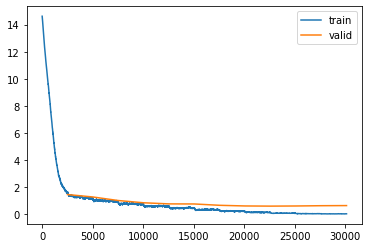

In [21]:
learner.recorder.plot_loss()

In [22]:
learner.save('model')

In [23]:
learner.load('model')

## Error analysis

In [24]:
o = learner.get_preds()